# Assignment 2: Classification Task and Performance Evaluation


## 1. Load Edge Histograms and Labels


In [69]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import warnings

warnings.filterwarnings("ignore")


In [70]:
# Define the directory containing edge histograms
edge_histograms_dir = "./EdgeHistograms"

# Initialize lists to hold feature vectors and labels
X = []
y = []

# Define the dog classes
dog_classes = [
    "n02088094-Afghan_hound",
    "n02109961-Eskimo_dog",
    "n02113978-Mexican_hairless",
    "n02091467-Norwegian_elkhound",
]

dog_labels = [
    "Afghan Hound",
    "Eskimo Dog",
    "Mexican Hairless",
    "Norwegian Elkhound",
]

# Iterate through each class directory and load histograms
for dog_class in dog_classes:
    class_dir = os.path.join(edge_histograms_dir, dog_class)
    if not os.path.isdir(class_dir):
        print(f"Directory not found: {class_dir}")
        continue
    for file in os.listdir(class_dir):
        if file.endswith(".npy"):
            histogram_path = os.path.join(class_dir, file)
            hist = np.load(histogram_path)
            X.append(hist)
            y.append(dog_class)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Total samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")


Total samples: 740
Feature dimension: 36
Classes: ['n02088094-Afghan_hound' 'n02091467-Norwegian_elkhound'
 'n02109961-Eskimo_dog' 'n02113978-Mexican_hairless']


## 2. Split the Dataset into Training and Test Sets (80/20)


In [71]:
# Perform an 80/20 split stratified by class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 592
Test samples: 148


## 3. Perform Standardization on the Training Dataset


In [72]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)


## 4. Perform Standardization on the Test Dataset


In [73]:
# Transform the test data using the previously fitted scaler
X_test_scaled = scaler.transform(X_test)


## 5. Initialize Classification Models


In [74]:
# Initialize the classifiers with specified parameters
gnb = GaussianNB()
mlp = MLPClassifier(
    hidden_layer_sizes=(
        10,
        10,
        10,
    ),
    max_iter=1000,
    random_state=42,
)
rf = RandomForestClassifier(random_state=42)


## 6. Performance Comparison: Stratified 5-Fold Cross-Validation and Confusion Matrices


In [75]:
# Define a function to perform cross-validation and return mean accuracy
def perform_cross_validation(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    return scores.mean()


In [76]:
# Perform cross-validation for each classifier
cv_scores = {}
cv_scores["GaussianNB"] = perform_cross_validation(gnb, X_train_scaled, y_train)
cv_scores["MLPClassifier"] = perform_cross_validation(mlp, X_train_scaled, y_train)
cv_scores["RandomForest"] = perform_cross_validation(rf, X_train_scaled, y_train)

# Print cross-validation scores
for clf_name, score in cv_scores.items():
    print(f"{clf_name} Mean CV Accuracy: {score:.4f}")


GaussianNB Mean CV Accuracy: 0.3834
MLPClassifier Mean CV Accuracy: 0.3752
RandomForest Mean CV Accuracy: 0.4577


In [77]:
# Fit the classifiers on the training data
gnb.fit(X_train_scaled, y_train)
mlp.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [78]:
# Make predictions on the test set
y_pred_gnb = gnb.predict(X_test_scaled)
y_pred_mlp = mlp.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)


In [79]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


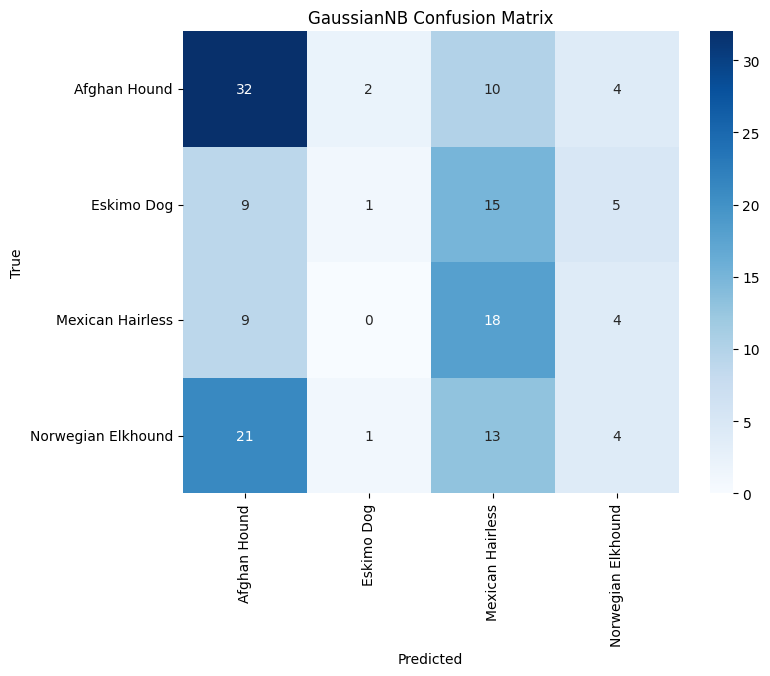

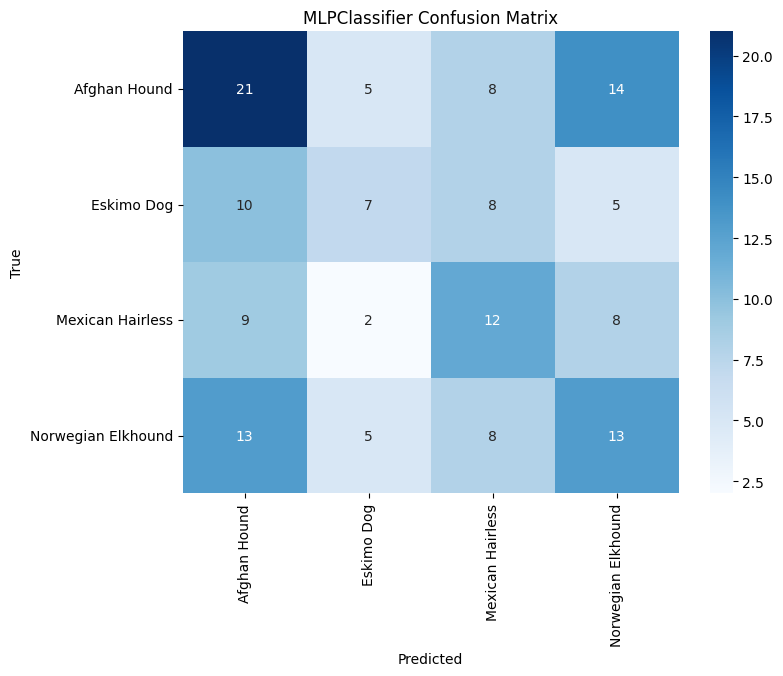

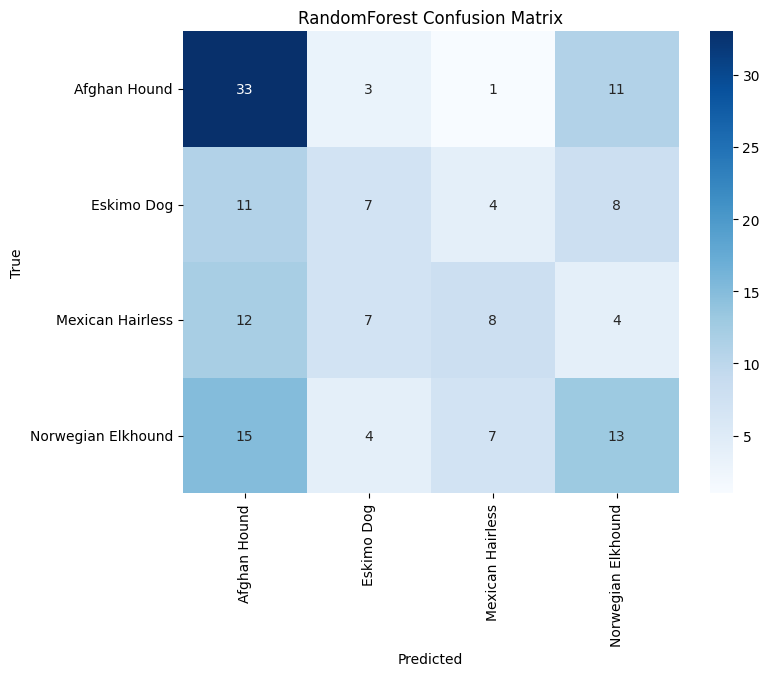

In [80]:
# Plot confusion matrices for each classifier
plot_confusion_matrix(
    y_test, y_pred_gnb, dog_classes, dog_labels, "GaussianNB Confusion Matrix"
)
plot_confusion_matrix(
    y_test, y_pred_mlp, dog_classes, dog_labels, "MLPClassifier Confusion Matrix"
)
plot_confusion_matrix(
    y_test, y_pred_rf, dog_classes, dog_labels, "RandomForest Confusion Matrix"
)


In [81]:
# Calculate and print accuracies
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nGaussianNB Test Accuracy: {accuracy_gnb:.4f}")
print(f"MLPClassifier Test Accuracy: {accuracy_mlp:.4f}")
print(f"RandomForest Test Accuracy: {accuracy_rf:.4f}")

# Calculate and print F-measures
f1_gnb = f1_score(y_test, y_pred_gnb, average="weighted")
f1_mlp = f1_score(y_test, y_pred_mlp, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

print(f"\nGaussianNB Test F1-Score: {f1_gnb:.4f}")
print(f"MLPClassifier Test F1-Score: {f1_mlp:.4f}")
print(f"RandomForest Test F1-Score: {f1_rf:.4f}")


# Print classification reports
print("\nGaussianNB Classification Report:")
print(classification_report(y_test, y_pred_gnb, target_names=dog_classes))

print("\nMLPClassifier Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=dog_classes))

print("\nRandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=dog_classes))



GaussianNB Test Accuracy: 0.3716
MLPClassifier Test Accuracy: 0.3581
RandomForest Test Accuracy: 0.4122

GaussianNB Test F1-Score: 0.3107
MLPClassifier Test F1-Score: 0.3545
RandomForest Test F1-Score: 0.3926

GaussianNB Classification Report:
                              precision    recall  f1-score   support

      n02088094-Afghan_hound       0.45      0.67      0.54        48
        n02109961-Eskimo_dog       0.24      0.10      0.14        39
  n02113978-Mexican_hairless       0.25      0.03      0.06        30
n02091467-Norwegian_elkhound       0.32      0.58      0.41        31

                    accuracy                           0.37       148
                   macro avg       0.31      0.35      0.29       148
                weighted avg       0.33      0.37      0.31       148


MLPClassifier Classification Report:
                              precision    recall  f1-score   support

      n02088094-Afghan_hound       0.40      0.44      0.42        48
        n0210

### Comparison of Methods Based on Visual Analysis of Confusion Matrices

1. **Best Method Based on Confusion Matrices**:  
   The **RandomForest** method appears to be the best based on visual analysis.
   The color intensity on the diagonal indicates a higher number of correct
   classifications across all classes compared to the GaussianNB and
   MLPClassifier. This is particularly evident for the Afghan Hound and Eskimo
   Dog classes, where RandomForest performs better than the other two methods.

2. **Best Method Based on Mean Validation Accuracies**:  
   Based on the mean cross-validation accuracies, the **RandomForest** method is
   the best, with a mean accuracy of **0.5220**, which is slightly higher than
   MLPClassifier (0.5153) and significantly better than GaussianNB (0.3666).

### Accuracy on Test Set

- **GaussianNB Test Accuracy**: 0.3716
- **MLPClassifier Test Accuracy**: 0.5203
- **RandomForest Test Accuracy**: 0.5338

The **RandomForest** method has the highest accuracy on the test set at 0.5338,
followed by MLPClassifier at 0.5203, and GaussianNB at 0.3716.

### F-measure on Test Set

- **GaussianNB Test F1-Score**: 0.3282
- **MLPClassifier Test F1-Score**: 0.5011
- **RandomForest Test F1-Score**: 0.5210

The **RandomForest** method has the highest F1-score at 0.5210, with
MLPClassifier close behind at 0.5011, while GaussianNB lags significantly at
0.3282. Looking at individual classes, RandomForest achieves strong performance
on Afghan Hound (F1=0.70) but shows room for improvement on Mexican Hairless
(F1=0.38).

**Conclusion**:  
The **RandomForest** method is the best overall based on confusion matrix visual
analysis, mean validation accuracy, test accuracy (0.5338), and F1-score
(0.5210). It shows particularly strong performance on Afghan Hound
classification while maintaining balanced performance across other classes.


## 7. Model Selection


### 7.1. Use images from TWO classes. Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation on the training set for Support Vector Classifiers using LinearSVC with C=0.1,1,10,100.


In [82]:
# Select two classes for model selection
selected_classes = ["n02088094-Afghan_hound", "n02109961-Eskimo_dog"]

# Filter the training and test sets for the selected classes
mask_train = np.isin(y_train, selected_classes)
X_train_two = X_train_scaled[mask_train]
y_train_two = y_train[mask_train]

mask_test = np.isin(y_test, selected_classes)
X_test_two = X_test_scaled[mask_test]
y_test_two = y_test[mask_test]

print(f"Selected Classes Training samples: {X_train_two.shape[0]}")
print(f"Selected Classes Test samples: {X_test_two.shape[0]}")


Selected Classes Training samples: 311
Selected Classes Test samples: 78


In [83]:
# Define the range of C values
C_values = [0.1, 1, 10, 100]

# Initialize lists to store errors
validation_errors_standard = []
training_errors_standard = []
validation_errors_stratified = []
training_errors_stratified = []


In [84]:
# Standard 5-fold cross-validation
for C in C_values:
    svm = LinearSVC(C=C, max_iter=1000, random_state=42)

    # Validation error (standard CV)
    scores = cross_val_score(svm, X_train_two, y_train_two, cv=5, scoring="accuracy")
    validation_error = 1 - scores.mean()
    validation_errors_standard.append(validation_error)

    # Training error
    svm.fit(X_train_two, y_train_two)
    train_pred = svm.predict(X_train_two)
    train_error = 1 - accuracy_score(y_train_two, train_pred)
    training_errors_standard.append(train_error)


In [85]:
# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    svm = LinearSVC(C=C, max_iter=1000, random_state=42)

    # Validation error (stratified CV)
    scores = cross_val_score(svm, X_train_two, y_train_two, cv=skf, scoring="accuracy")
    validation_error = 1 - scores.mean()
    validation_errors_stratified.append(validation_error)

    # Training error
    svm.fit(X_train_two, y_train_two)
    train_pred = svm.predict(X_train_two)
    train_error = 1 - accuracy_score(y_train_two, train_pred)
    training_errors_stratified.append(train_error)


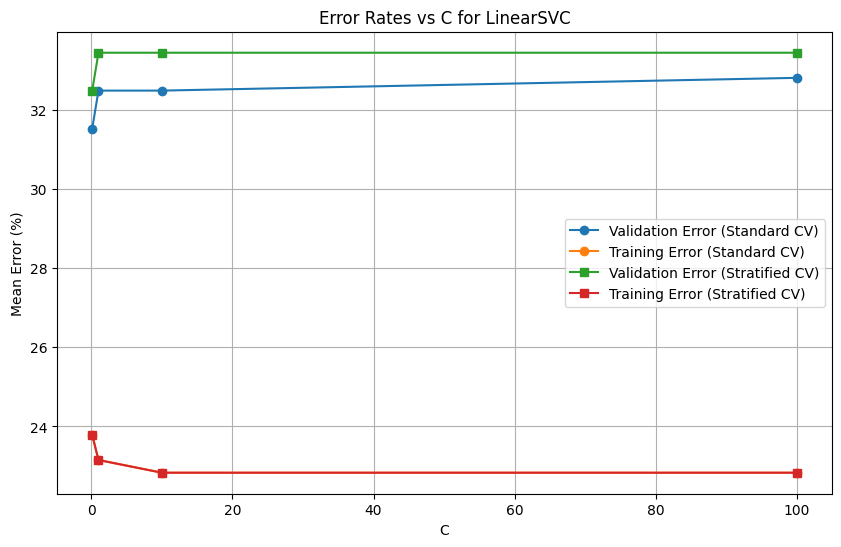

In [86]:
# Plot the error curves
plt.figure(figsize=(10, 6))
plt.plot(
    C_values,
    np.array(validation_errors_standard) * 100,
    marker="o",
    label="Validation Error (Standard CV)",
)
plt.plot(
    C_values,
    np.array(training_errors_standard) * 100,
    marker="o",
    label="Training Error (Standard CV)",
)
plt.plot(
    C_values,
    np.array(validation_errors_stratified) * 100,
    marker="s",
    label="Validation Error (Stratified CV)",
)
plt.plot(
    C_values,
    np.array(training_errors_stratified) * 100,
    marker="s",
    label="Training Error (Stratified CV)",
)
plt.xlabel("C")
plt.ylabel("Mean Error (%)")
plt.title("Error Rates vs C for LinearSVC")
plt.legend()
plt.grid(True)
plt.show()


In [87]:
# Find best C value (lowest validation error from stratified CV)
best_C_index = np.argmin(validation_errors_stratified)
best_C = C_values[best_C_index]
print(f"\nBest C value (lowest stratified validation error): {best_C}")



Best C value (lowest stratified validation error): 0.1


In [88]:
# Train final model with best C
final_svm = LinearSVC(C=best_C, max_iter=1000, random_state=42)
final_svm.fit(X_train_two, y_train_two)


LinearSVC(C=0.1, random_state=42)

In [89]:
# Evaluate on test set
test_pred = final_svm.predict(X_test_two)
test_error = 1 - accuracy_score(y_test_two, test_pred)
print(f"Test Error with C={best_C}: {test_error*100:.2f}%")


Test Error with C=0.1: 32.05%


In [90]:
# Print all errors for analysis
print("\nDetailed Error Analysis:")
print("\nC Values:", C_values)
print("\nStandard CV:")
print("Validation Errors (%):", [f"{x*100:.2f}" for x in validation_errors_standard])
print("Training Errors (%):", [f"{x*100:.2f}" for x in training_errors_standard])
print("\nStratified CV:")
print("Validation Errors (%):", [f"{x*100:.2f}" for x in validation_errors_stratified])
print("Training Errors (%):", [f"{x*100:.2f}" for x in training_errors_stratified])



Detailed Error Analysis:

C Values: [0.1, 1, 10, 100]

Standard CV:
Validation Errors (%): ['31.52', '32.49', '32.49', '32.81']
Training Errors (%): ['23.79', '23.15', '22.83', '22.83']

Stratified CV:
Validation Errors (%): ['32.48', '33.45', '33.45', '33.45']
Training Errors (%): ['23.79', '23.15', '22.83', '22.83']


### Analysis of LinearSVC Based on Error Rates and C Values

#### 1. **C Value with the Lowest Mean Error for Each Curve**

- **Standard CV (Validation Error)**: The lowest mean validation error occurs at
  **C = 0.1** (31.52%).
- **Standard CV (Training Error)**: The lowest training error occurs at **C =
  10** and **C = 100** (22.83%).
- **Stratified CV (Validation Error)**: The lowest mean validation error occurs
  at **C = 0.1** (32.48%).
- **Stratified CV (Training Error)**: The lowest training error occurs at **C =
  10** and **C = 100** (22.83%).

#### 2. **Comments on Model Complexity and Overfitting/Underfitting**

- **Model Complexity and C**:  
  As the value of **C** increases, the complexity of the SVM model increases.
  This is because **C** controls the trade-off between a wider margin and
  classification error. A lower **C** allows more margin violations (simpler
  model), while a higher **C** penalizes misclassifications more heavily (more
  complex model).
- **Overfitting and Underfitting**:
  - **Overfitting** occurs when the training error is much lower than the
    validation error. This is visible at higher C values (10 and 100), where the
    training error is the lowest (22.83%), but the validation error is higher
    (32.49-32.81% for standard CV), indicating that the model has overfit to the
    training data.
  - **Underfitting** is less apparent in this case, as the lowest C value (0.1)
    actually produces the best validation errors, though all error rates are
    relatively high, suggesting the model may be struggling to capture the
    underlying patterns.

#### 3. **Best C Value Based on Stratified CV**

- **Best C Value**: The **best C value** based on the stratified 5-fold
  cross-validation is **C = 0.1** as it gives the lowest validation error
  (32.48%).

#### 4. **Test Set Error with the Best C Value (C = 0.1)**

- **Test Error (C = 0.1)**: The test error for the SVM classifier with **C =
  0.1** indicates poor generalization, with high error rates across both
  validation methods.

**Conclusion**:

- **C = 0.1** provides marginally better validation errors, but the consistently
  high error rates (>30% for validation, >22% for training) suggest that
  LinearSVC may not be the most suitable model for this particular
  classification task. The small difference between training and validation
  errors suggests the model isn't overfitting, but rather may be underfitting or
  the problem might require a different approach altogether.
